# Transformer

In 2017, researchers at Google published a paper called [Attention Is All You Need](https://arxiv.org/abs/1706.03762) that proposed a novel neural network architecture for sequence modeling. Dubbed the **Transformer**, this architecture outperformed recurrent neural networks on machine translation tasks, both in terms of translation quality and training cost.

## Abstract

This notebook explores the Attention Is All You Need paper and the Transformer architecture. Additionally, a pre-trained transformer model is fine-tuned for performing sentiment analysis on the IMDb movie reviews dataset.

## Table of Contents

>[Transformer](#scrollTo=RgWKmpwOC13T)

>>[Abstract](#scrollTo=tYNMHILxDABI)

>>[Table of Contents](#scrollTo=prfVsIAYDCDu)

>>[Background](#scrollTo=eJbMBp2uDvY7)

>>[Transformer Architecture](#scrollTo=qAZBhvTXFQVR)

>>[Positional Encoding](#scrollTo=2PLmGQ8mBHOq)

>>[Encoder and Decoder Stacks](#scrollTo=bD3JXGXFGc7Z)

>>>[Encoder](#scrollTo=y_ZVV1xoG4pA)

>>>[Decoder](#scrollTo=6Q_6v7HSG51a)

>>[Attention](#scrollTo=xBSxj1ABI-Wc)

>>>[Intuition behind Self-Attention](#scrollTo=JL1kaSjAMIff)

>>>[Understanding Attention with Search](#scrollTo=L2HwSq60NSFC)

>>>[Scaled Dot-Product Attention](#scrollTo=1soSiJKnfjUq)

>>>[Multi-Head Attention](#scrollTo=_Q-CO8zKBI2L)

>>[Position-wise Feed-Forward Networks](#scrollTo=UGrbWCXXUtzs)

>>[Fine-Tuning a 🤗Transformer for Sentiment Analysis](#scrollTo=om6Kabx3aXh9)

>>>[Transfer Learning and Pretrained Transformers](#scrollTo=EaXSnmjaaavp)

>>>[Setup](#scrollTo=ySishG1iJmSd)

>>>[Imports](#scrollTo=CvHkomOab83X)

>>>[Loading the Dataset](#scrollTo=jBEuRn_gJpqt)

>>>[Tokenization](#scrollTo=cKukPr9pKBhe)

>>>[Data Collation](#scrollTo=O5A4WPpyTd2O)

>>>[Model Fine-Tuning](#scrollTo=-DNVX-UTUAw9)

>>>[Inference](#scrollTo=Dw36FLOi6APT)



## Background

Prior to <font color="hotpink">transformers</font>, <font color="hotpink">recurrent neural networks</font>, <font color="hotpink">long short-term memory</font> and <font color="hotpink">gated recurrent neural networks</font> have been firmly established as the state-of-the-art approaches in sequence modeling and transduction problems such as language modeling and machine translation. Recurrent models typically factor computation along the symbol positions of the input and output sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden states $h_t$, as a function of the previous hidden state $h_{t-1}$ and the input for position $t$.

One area where RNNs played an important role was in the development of machine translation systems. This kind of task is usually tackled with an <font color="hotpink">encoder-decoder</font> or <font color="hotpink">sequence-to-sequence</font> architecture, which is suited for situations where the input and output are both sequences of arbitrary length. The encoder encodes the information from the input sequence into a numerical representation: the last hidden state, which is then passed to the decoder to generate the conditioned output sequence.

Although elegant in its simplicity, one weakness of this architecture is that the final hidden state of the encoder creates an information bottleneck: it has to represent the meaning of the whole input sequence because this is all the decoder has access to when generating the output. This is especially challenging for long sequences, where information at the start of the sequence might be lost in the process of compressing everything to a single, fixed representation. Fortunately, there is a way out of this bottleneck by allowing the decoder to have access to all of the encoder’s hidden states. The general mechanism for this is called <font color="hotpink">attention</font>, and it is a key component in many modern neural network architectures. 

<font color="hotpink">Attention</font> mechanisms have become an integral part of compelling sequence modeling and transduction models in various tasks, allowing modeling of dependencies without regard to their distance in the input or output sequences. The main idea behind attention is that instead of producing a single hidden state for the input sequence, the encoder outputs a hidden state at each step that the decoder can access. However, using all the states at the same time would create a huge input for the decoder, so some mechanism is needed to prioritize which states to use. This is where attention comes in: it lets the decoder assign a different amount of weight, or “attention,” to each of the encoder states at every decoding time-step. 

Although attention enabled the production of much better translations, there was still a major shortcoming with using recurrent models for the encoder and decoder: the computations are inherently sequential and cannot be parallelized across the input sequence. With the <font color="hotpink">transformer</font>, a new modeling paradigm was introduced: dispense with recurrence altogether, and instead rely entirely on a special form of attention called self-attention. 

## Transformer Architecture

Transformers follow the encoder-decoder structure. The encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $z = (z_1, ..., z_n)$. Given $z$, the decoder then generates an output sequence $(y_1, ..., y_m)$ of symbols one element at a time. At each step the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next.

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of the following figure, respectively.

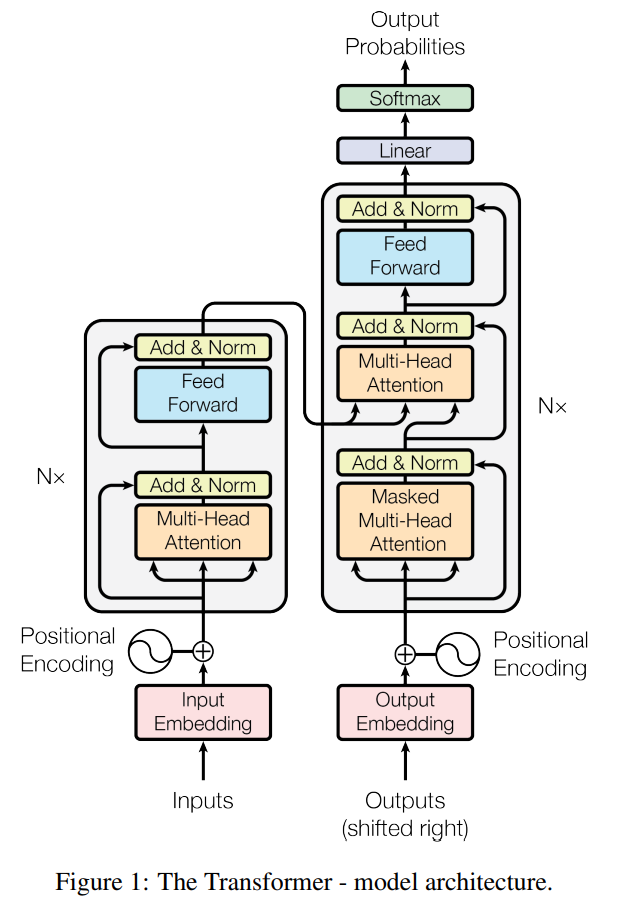

## Positional Encoding

Transformer models rely solely on attention. Transformers do not process the input in order, sequentially, but in parallel. The lack of recurrence/convolutions means that a positional encoding vector of the tokens must be provided to the model so it has some information about the relative position of the tokens in the sentence.

This positional encoding vector is added to the token embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of the tokens in a sentence. So after adding the positional encoding, tokens will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

As shown in the figure below, the initial token embedding vectors for `Queen` and `King` are close to each other due to their semantic similarity. By adding the positional encoding vector which identifies the order of the tokens, the `Queen` token is slightly shifted towards the tokens cluster with similar position in sentences.

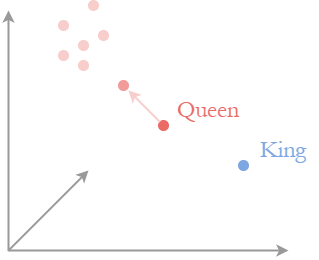

These positional encodings must satisfy the following properties:

- Every position should have the same positional encoding vector irrespective of the input.

- Their magnitude should not be too large; otherwise, the shift becomes too strong causing the positional similarity to overshadow the semantic one.

- Their magnitude should not be too small; otherwise, the shift becomes too weak causing the semantic similarity to overshadow the positional one.

A straightforward positional encoding function might be the following simple linear relationship between tokens' positions and their corresponding positional encoding. However, this results problematic with long sequences as it violates the desired property of having bounded positional encodings.

Meanwhile, the sine and cosine functions are bounded and periodically returning to values in the range $[-1, 1]$. They're also defined up to infinity so they work with very long sequences (unlike the sigmoid function which has very little variability for larger domain values).

Shown below are the two functions across a single dimension.

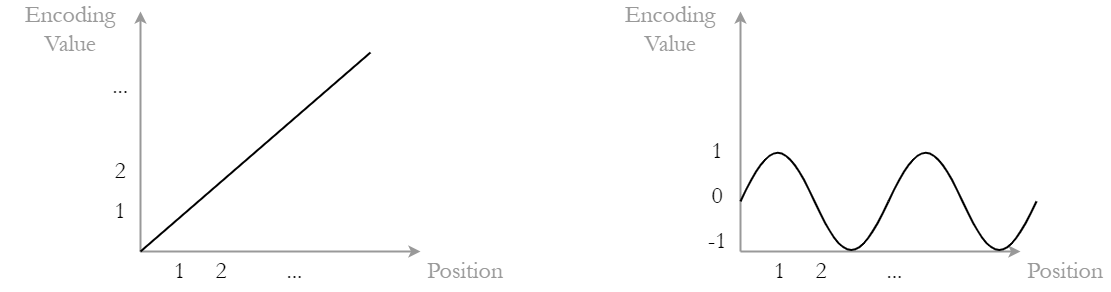

The issue with this sine function is its periodicity will give certain tokens at different positions the same encoding value. A naive solution would be to use a wave with such a low frequency that even the longest sequence, the values would not repeat. This violates the desired property of having encoding vectors that aren't too small. However, this problem is easily solved by using sines and cosine of different frequencies across different dimensions.

The original transformer paper uses sine and cosine functions of different frequencies approach:

<center><h1>$PE(pos, 2i)=sin(pos/10000^{2i/d_{model}})$</h1></center>
<center><h1>$PE(pos, 2i+1)=cos(pos/10000^{2i/d_{model}})$</h1></center>

where $pos$ is the position and $i$ is the dimension. 


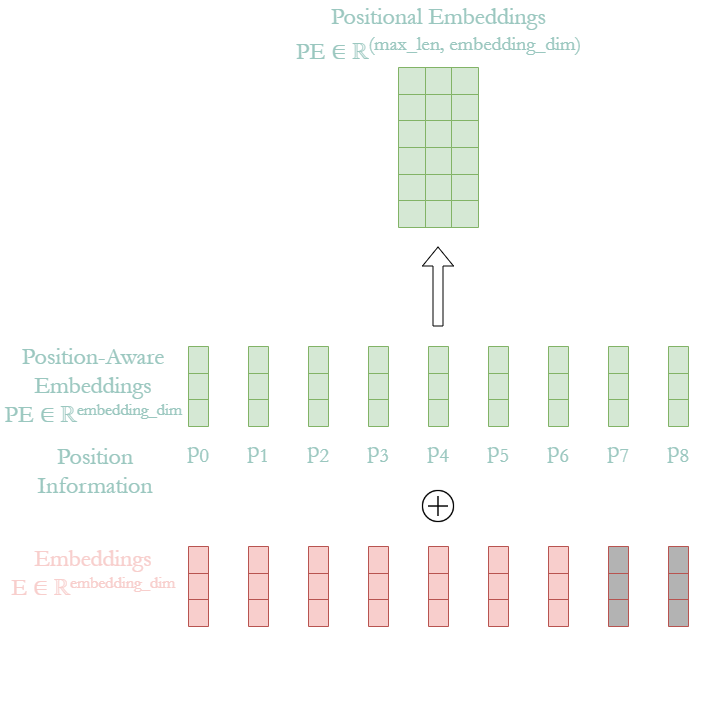

While the paper produces the final embeddings by an addition operation between the semantic and positional vectors, there are other approaches such as concatenating the two vectors. This increases the embedding space dimensionality so that the semantic dimensions are orthogonal to the positional ones. Thus, avoiding any mix up between the two vectors. However, this comes at the cost of more memory, parameters, and computation time.

Finally, some efforts have been done for models to self-learn the positional encodings. However, the learned encodings have not been able to consistently outperform their handcrafted counterparts.

## Encoder and Decoder Stacks

### Encoder

- The encoder is composed of a stack of $N = 6$ identical layers.
- Each layer has the following two sub-layers.
  - A multi-head self-attention mechanism.
  - A position-wise fully connected feed-forward network.

- Residual connections are employed around each of the two sub-layers, followed by layer normalization. That is, the output of each sub-layer is $LayerNorm(x + Sublayer(x))$, where $Sublayer(x)$ is the function implemented by the sub-layer
itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{model} = 512$.

### Decoder

- The decoder is also composed of a stack of $N = 6$ identical layers. 
- In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack.
- Similar to the encoder, residual connections are employed around each of the three sub-layers.
- The self-attention sub-layer in the decoder stack is modified to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the
predictions for position $i$ can depend only on the known outputs at positions less than $i$.

## Attention



### Intuition behind Self-Attention

Self-attention is the ability to take an input and "attend" to the most important parts to that input (with respect to a query).

Consider the following image:

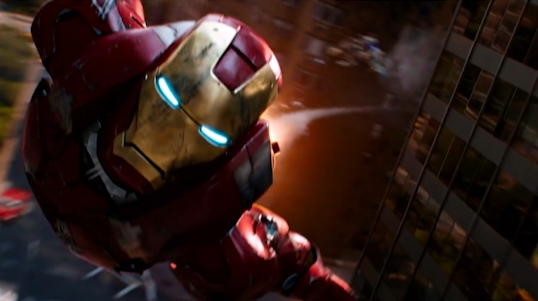

Assuming our query is "superhero", then the self-attention mechanism should attend to the pixels that make up iron man:

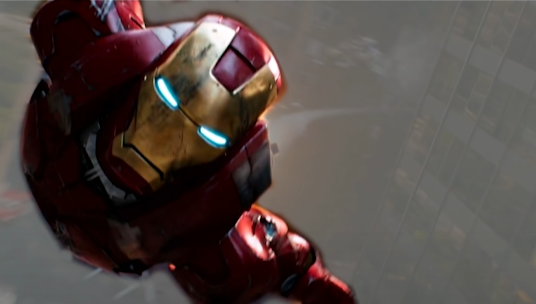

Finally, multi-head attention refers to the ability to attend to different things in the input as shown below:

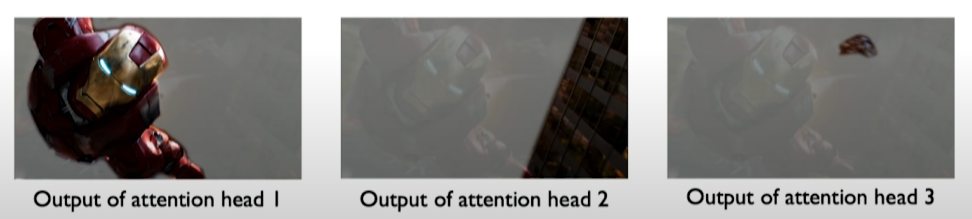

### Understanding Attention with Search

YouTube is a giant database of many videos. The goal is to find/attend to a certain video. The first step is specifying some query $q$ in the search bar. What can be done next is as follows: for every video in the database, extract some key information $k$ which can simply be the video's title.

At this point, we have a query $q$ and a set of keys $(k_1, ..., k_n)$. To do the search, we compute a similary function between the query and each of the keys. The output of this computation is an attention mask, that provides an attention weighting to every key according to the query.

The final step is to extract the actual video based on the attention weights. This is called the value $v$. 

### Scaled Dot-Product Attention

The attention function used by a transformer takes three input matrices: $Q$ (Queries), $K$ (Keys), $V$ (Values). The equation used to calculate the attention vector is:

<center><h1>$Attention(Q, K, V)=softmax(\frac{QK^T}{\sqrt{d_k}})V$</h1></center>

The mask layer is employed in the decoder's self-attention step. It is multiplied with -1e9 (close to negative infinity). This is  because the mask is summed with the scaled matrix multiplication of $Q$ and $K$ and is applied immediately before a softmax. The goal is to zero out the part of the decoder's input that the model shouldn't have access to yet, and large negative inputs to softmax are near zero in the output.

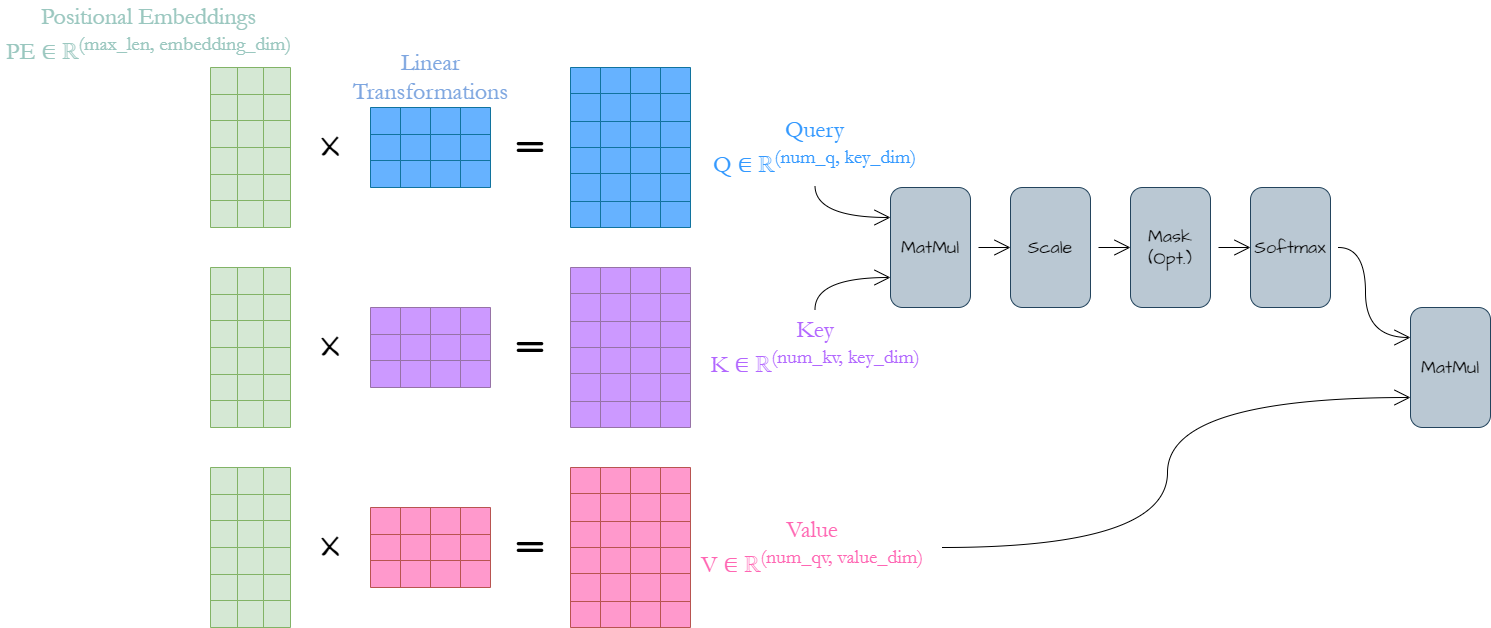

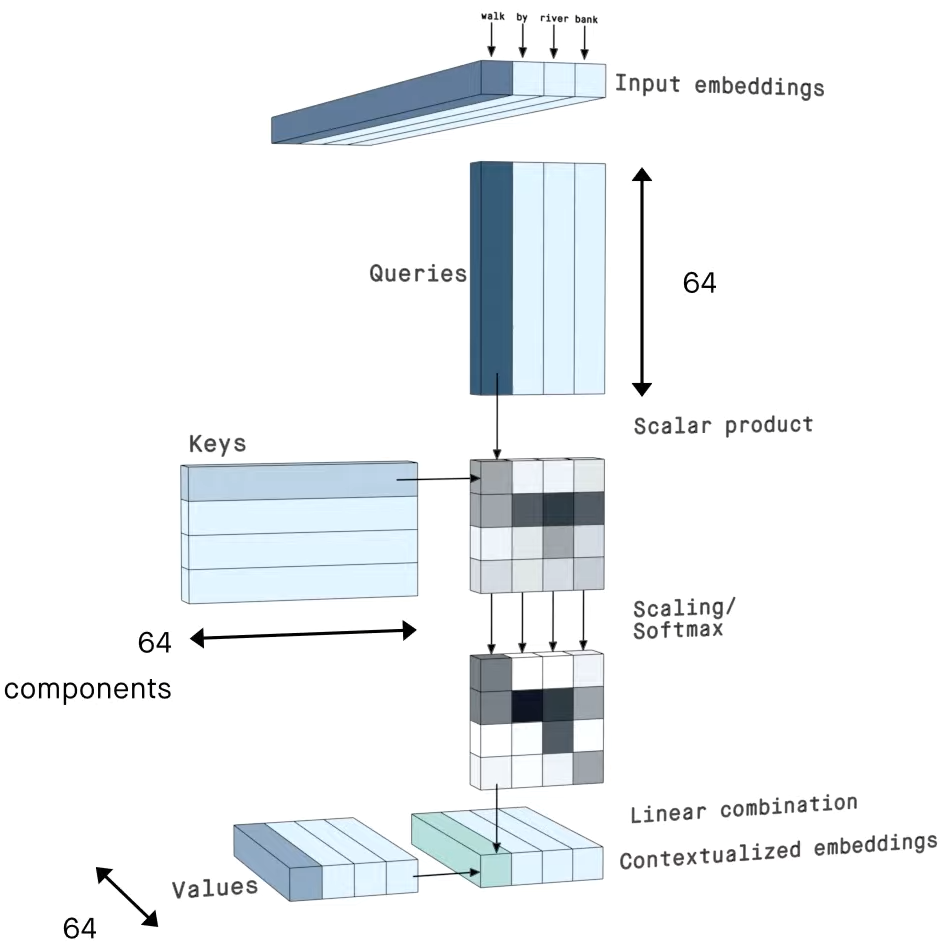

### Multi-Head Attention



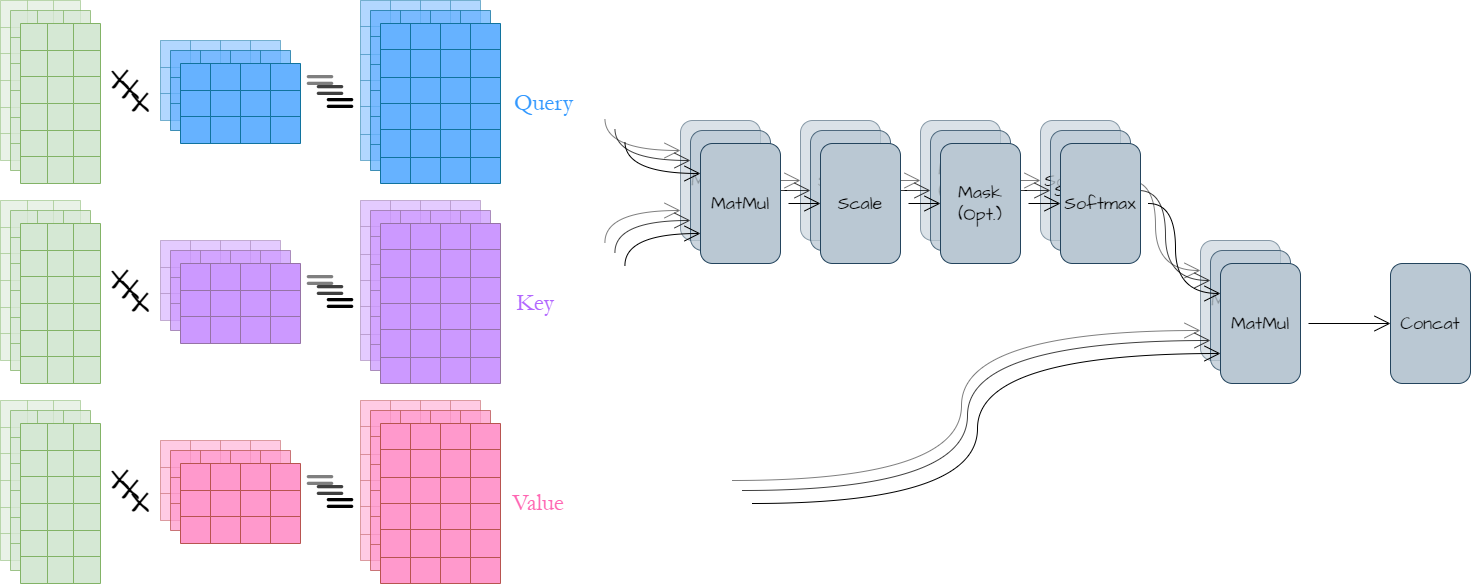

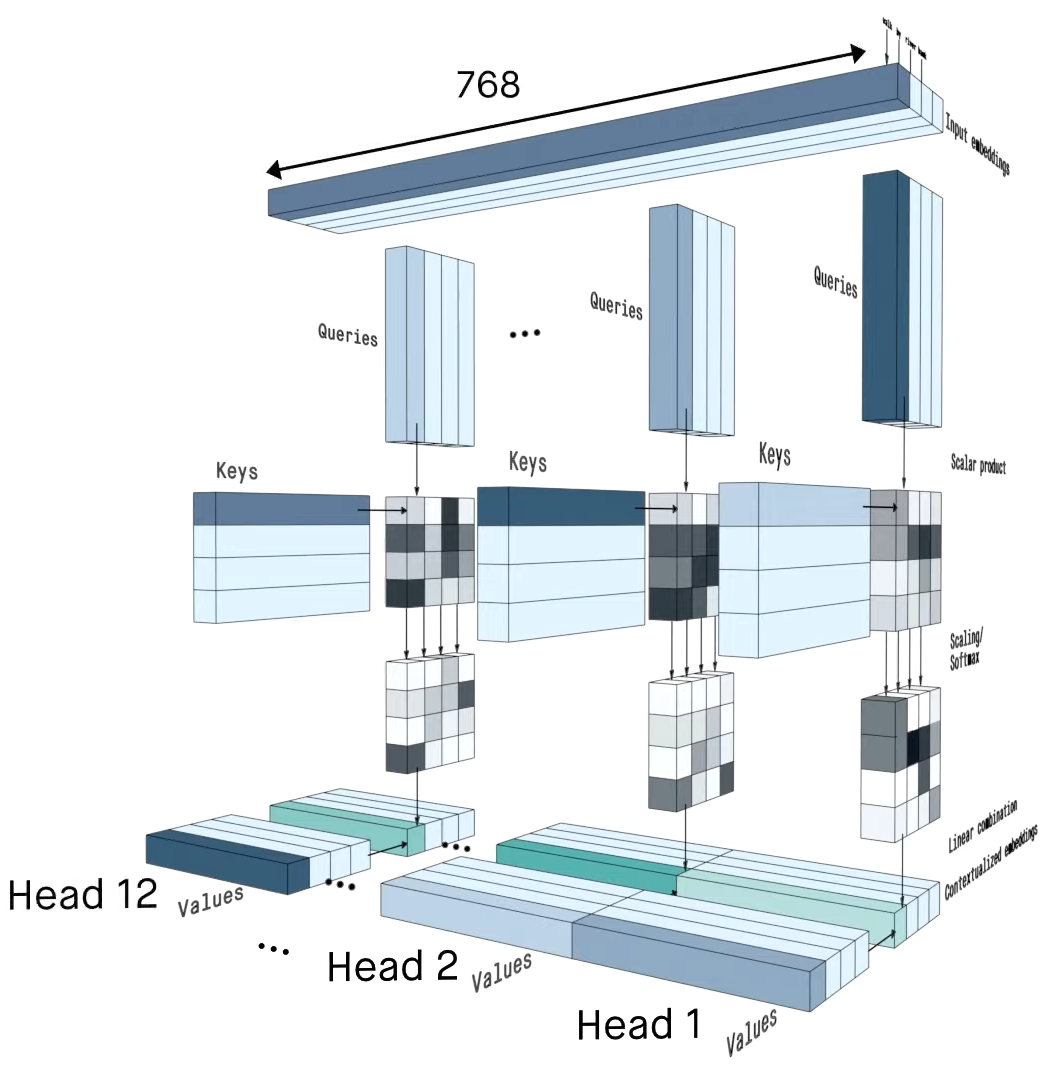

## Position-wise Feed-Forward Networks

Each of the layers in the encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

$FFN(x) = max(0, xW_1 + b_1)W_2 + b_2$

## Fine-Tuning a 🤗Transformer for Sentiment Analysis

This section fine-tunes a `DistilBERT` model on the IMDb dataset to determine whether the sentiment of a movie review is positive or negative.

### Transfer Learning and Pretrained Transformers

This notebook uses `DistilBERT` to train a text classifier. Specifically, it takes the pre-trained `DistilBERT` model, adds an untrained layer at the end, and trains the new model for our classification task. Why do this rather than train a specific model that is well suited for the NLP task in question? 

1. **Less Data**

    * A major drawback of transformer models built and trained from scratch is that they often require a prohibitively large dataset to train to a reasonable accuracy. This method allows us to fine-tune our task on a much smaller dataset than would be required in a model built from scratch. 

2. **Quicker Development**

    * The pre-trained `DistilBERT` model weights already encode a lot of information about the language. As a result, it takes much less time to train the fine-tuned model as most of the work at the bottom layers is already done.

    Since the bottom layers are already extensively trained, only slightly tuning them while using their output as features for the classification task is needed. This means only 2-4 epochs of training for fine-tuning on a specific NLP task (compared to the hundreds of GPU hours needed to train the original  model from scratch). 


3. **Better Results**

    * This simple fine-tuning procedure (typically adding one fully-connected layer on top of the pretrained transformer and finetuning for a few epochs) was shown to achieve state-of-the-art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architectures that work well on a specific task, simply fine-tuning a transformer is shown to be a better (or at least equal) alternative.

### Setup

Installs the most recent versions of 🤗Transformers and 🤗Datasets.

In [1]:
!pip install -q transformers
!pip install -q datasets

     |████████████████████████████████| 4.9 MB 4.9 MB/s 
     |████████████████████████████████| 163 kB 71.8 MB/s 
     |████████████████████████████████| 6.6 MB 44.1 MB/s 
     |████████████████████████████████| 432 kB 4.8 MB/s 
     |████████████████████████████████| 115 kB 47.1 MB/s 
     |████████████████████████████████| 212 kB 67.3 MB/s 
     |████████████████████████████████| 127 kB 70.0 MB/s 


### Imports

In [2]:
import numpy as np
import tensorflow as tf

from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import create_optimizer, TFAutoModelForSequenceClassification

### Loading the Dataset

Load the IMDb movie reviews dataset from the 🤗Datasets library.

The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, and validation. To access an instance element, a split should first be specified, then an index.

In [3]:
imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

As shown below, the dataset consists of the following sets:

- A `train` dataset of 25k examples.
- A `test` dataset of 25k examples.

In [4]:
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
imdb["train"][0]["text"]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

### Tokenization

Before the text can be fed to the model, it first must be preprocessed. This is done by a 🤗Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and structure it in a format the model expects, as well as generate the other inputs that model requires.

Thus, a tokenizer is instanciated with the `AutoTokenizer.from_pretrained` method, which will ensure:

- Getting a tokenizer that corresponds to the model architecture we want to use,
- Downloading the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time the cell is run.

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Creates a `preprocess` function to be applied over the entirety of the dataset.

In [7]:
def preprocess(instances):

  # truncation=True ensures that an input longer that what the selcted model
  # can handle will be truncated to the maximum length accepted by the model.
  return tokenizer(instances["text"], truncation=True)

Use 🤗Datasets `map` function to apply the preprocessing function over the entire dataset. The function is sped up by setting `batched=True` as it processes multiple elements of the dataset at once.

In [8]:
tokenized_imdb = imdb.map(preprocess, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

### Data Collation

Use `DataCollatorWithPadding` to create a batch of examples. It will also dynamically pad the text to the length of the longest element in its batch, so they are a uniform length. While it is possible to pad the text in the tokenizer function by setting `padding=True`, dynamic padding is more efficient.

Convert the dataset splits to `tf.data.Dataset`, which Keras understands natively. There are two ways to do this:

1. Use the slightly more low-level `Dataset.to_tf_dataset()` method.
2. Use the `Model.prepare_tf_dataset()` method.

The main difference is that the Model method can inspect the model to determine which column names it can use as input, which means they don't need to be explicitly specified. Unless the samples are all the same length, a tokenizer or a collate function must be passed so that the `tf.data.Dataset` knows how to pad and combine samples into a batch.

In [9]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [10]:
batch_size = 16

tf_train_set = tokenized_imdb["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = tokenized_imdb["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


### Model Fine-Tuning

Instanciate an optimizer object.

In [11]:
num_epochs = 4
batches_per_epoch = len(tokenized_imdb["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

Load `DistilBERT` with `TFAutoModelForSequenceClassification` along with the number of expected labels. Like with the tokenizer, the `from_pretrained` method will download and cache the model.

In [12]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [13]:
model.compile(optimizer=optimizer)
model.fit(x=tf_train_set, epochs=num_epochs)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/4
1563/1563 [==============================] - 1438s 913ms/step - loss: 0.2477
Epoch 2/4
1563/1563 [==============================] - 1428s 913ms/step - loss: 0.1313
Epoch 3/4
1563/1563 [==============================] - 1430s 915ms/step - loss: 0.0624
Epoch 4/4
1563/1563 [==============================] - 1427s 913ms/step - loss: 0.0328


### Inference

In [14]:
inference_examples = [
    "I loved it.",
    "It was awful!",
    "Meh.",
    "Pretty well made."
]

inference_examples_tokenized = tokenizer(inference_examples, return_tensors="np", padding="longest")
model_output = model(inference_examples_tokenized).logits

classifications = np.argmax(model_output, axis=1)
labeled_classification = ["Positive" if c == 1 else "Negative" for c in classifications]

softmax = tf.keras.activations.softmax(model_output)
confidence_scores = np.max(softmax, axis=1)

for i in range(len(classifications)):
  print(f"Review: {inference_examples[i]}\nSentiment: {labeled_classification[i]}\nConfidence Score: {round(confidence_scores[i] * 100, 2)}%\n\n")

Review: I loved it.
Sentiment: Positive
Confidence Score: 99.78%


Review: It was awful!
Sentiment: Negative
Confidence Score: 99.25%


Review: Meh.
Sentiment: Negative
Confidence Score: 63.64%


Review: Pretty well made.
Sentiment: Positive
Confidence Score: 96.96%


